# DATS6103 - Data Mining: Individual Project 2
*Data Mining Cocktail Recipes*

*Evan Carraway*

*April 9, 2019*

<img src="Bottles.jpg" width=800 style='border: 1px solid black;'>

Objective: The purpose of this project is to continue learning and improving skills in data mining and extracting information from raw data using Python by analyzing cocktail recipes on the Internet.

Due Date: April 9, 2019 by 4:30 PM

## Tasks
1. Scrape 2,000 cocktail recipes from the Internet
2. Identify and rank cocktail characteristics by overall popularity
3. Trend cocktail popularity over time by ingredient

## Subtasks
1. Create an effective presentation describing your data set of choice
2. Present the topic and the rationale on why you are picking that topic
3. Topic and its data MUST be complex and not at all obvious
4. The topic will be checked for plagiarism
5. State where the data came from
6. State your data cleaning and preprocessing
7. Your code needs to be working and be well commented
8. Your analysis needs to be clear, organized, and in depth
9. Indicate any classifications, clusters, associations/correlations, etc.
10. Discuss your predictions you might have and your reasoning behind them
11. Describe your learning processes
12. Present an overall conclusion

## Abstract

Cocktails have seen a resurgence in popularity over the past decade that continues into this year and many businesses are seeking to enter or expand on this market (Mitchell, 2018). As a result of analysis of changes in consumer preferences, even chains like Pizza Hut are offering cocktails (Wall, 2015). At the same time, businesses are using analytics to tweak their menus and drink recipes (Carr, 2012).

By analyzing cocktail recipes online, we can find insights into what types of cocktails have grown in popularity over time, as well as what ingredients should be stocked in bars today to make the most cocktail recipes. I will being using Python, BeautifulSoup and Selenium to scrape cocktail recipe websites as well as Pandas and a variety of data manipulation/visualization tools to normalize data, make predictions and derive insights.

## Assumptions and Questions

If one were to open a bar, you would want to have a good selection of popular cocktails for guests. The basic cocktails most people might be familiar with are the Old Fashioned, the Whiskey Sour and the Margarita as those have been the most popular in bars in the last several years (Millington, 2018). Given a limited budget for purchasing supplies and finite menu space, we would want to know what types of spirits would make the most drinks and what flavor profiles to target. I might like spirit-forward cocktails, but others might prefer sweet cocktails. Using these assumptions will give us a starting point to find and analyze data about cocktails from the Internet.

## Tools Used

For this exercise, we used Python 3 in Jupyter for interactive computing, with the Pandas data manipulation and analysis libraries, as well as the Plotly statistical data visualization library to generate interactive charts and figures. For data retrieval and parsing we will use Selenium and Beautifulsoup. For storage and retrieval of data sets we will use SQLite.

## Cocktail Recipe Website

The dataset we will be using for this project is the liquor.com cocktail recipe list. The site contains roughly 2,000 unique cocktails that have been added by users from 2009 to 2019. Recipes can be searched and accessed at https://www.liquor.com/recipe-search/

In [1]:
# Import required modules
import pandas as pd
import datetime
import time
import re
import io
import os
from IPython.core.display import Image, display
from PIL import Image as Im
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.firefox.options import Options
from bs4 import BeautifulSoup
from IPython.display import display, HTML
from sqlalchemy import create_engine
#import warnings
#import numpy as np
#import matplotlib
#import matplotlib.pyplot as plt
#from matplotlib.pyplot import figure
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

# Demo flag. Set to False to turn off screenshot and dataframe feedback
demo=True

# Hides code in HTML output
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Searching Websites with Python and Selenium
We could use the requests library to get individual recipes based on URL, but to get a list of URLs, we need to use the site's search tool. That said, the search tool requires interacting with a drop down filter box and checking boxes or typing terms for the different cocktail ingredients, which would go beyond a simple request and would require digging further into the REST calls and APIs, or we could do it manually. To avoid this and programatically navigate the search page, we will use Selenium.

Selenium is a tool that automates browsers, such as Chrome or Firefox. Selenium is primarily used for testing websites, but can also be used to navigate and scrape data from them. The Selenium driver for Firefox also supports headless browsing, meaning we can launch the browser in the background without graphical resources and execute and interact with any Javascript-based rendering or form elements. Web scraping through an automated browser is slower than executing direct requests through Python, but often the limiting factor for scraping is Internet bandwidth and web server resources. In addition, with browser automation we can do more than retrieve just the source HTML from the page. We can also render and screenshot the page, which can be useful in a number of situations, including for demonstrating the process in a Jupyter notebook!

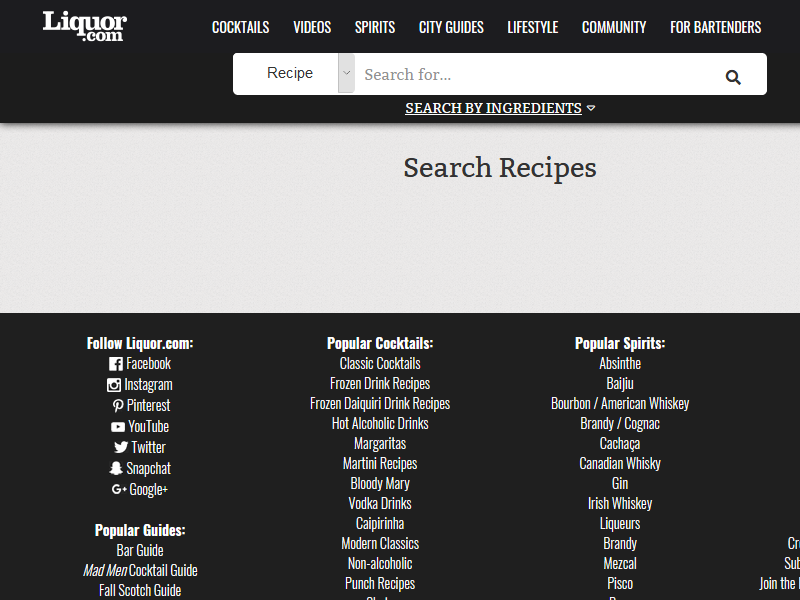

In [2]:
# Define destination URL
url = 'https://www.liquor.com/recipe-search/'

# Set options for Firefox private headless browser
firefox_options = Options()
firefox_options.add_argument("--headless")
firefox_profile = webdriver.FirefoxProfile()
firefox_profile.set_preference("browser.privatebrowsing.autostart", True)

# Launch headless browser and navigate to destination
browser = webdriver.Firefox(firefox_profile=firefox_profile,options=firefox_options)
browser.set_window_size(1000, 1000) 
browser.get(url)
browser.execute_script("document.body.style.zoom='.65'")
time.sleep(2)

# Render screenshot of page
png1 = browser.get_screenshot_as_png()
display(Im.open(io.BytesIO(png1)).crop((0,0,800,600)))

When navigating to the search page for the first time, a splash page may appear, which Selenium can click to close. Once on the page, we can automate the opening of the search drop down and the entering of ingredients. This can take a little time as interacting with the page causes more results to load. To not overwhelm the site, we add wait timers to pause after checking boxes or entering terms.

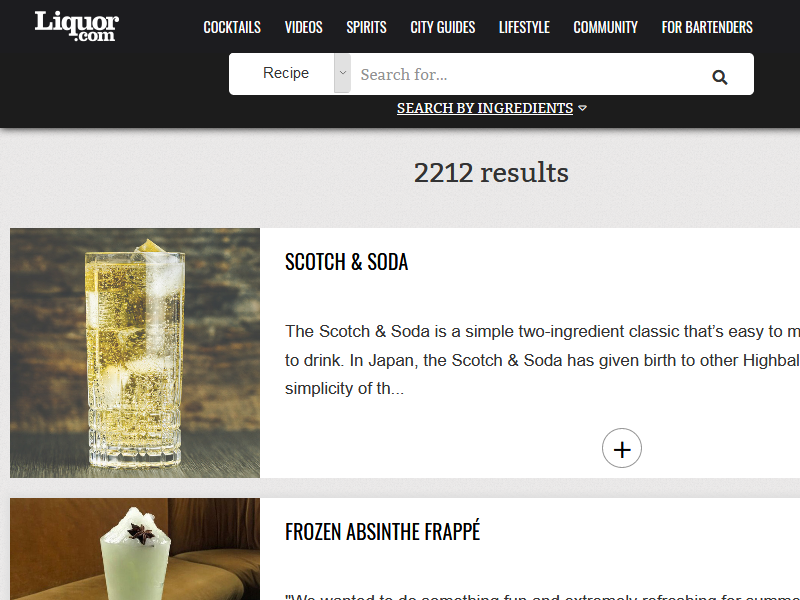

In [3]:
# Bypass splash page if visible
try:
    browser.find_element_by_xpath('//*[contains(text(),"I just want to see the content")]').click()
    time.sleep(1)
except:
    pass

# Open search dropdown
browser.find_element_by_xpath('//a[contains(@id,"toggle-filters")]').click()
time.sleep(1)

# Click option to search multiple ingredients separately
browser.find_element_by_xpath('//*[contains(@name,"strict_search")]').click()
time.sleep(1)

# Click search form text box
browser.find_element_by_xpath('//div[contains(@class,"selectize-input")]').click()
time.sleep(1)

# Enter all ingredients of interest
ingredients = ['Rum','Beer','Vodka','Gin','Bourbon','Bitters','Lime Juice','Lemon Juice','Whisky','Whiskey',
               'Absinthe','Aperol','Club Soda','Ginger Beer','Cognac','Egg White','Tequila','Wine','Vermouth'
              'Benedictine','Campari','Brandy','Pisco','Amaro','Soju','Champagne','Mezcal','Scotch']

# Loop through and type ingredients into search form
for ingredient in ingredients:
    browser.find_element_by_xpath('//input[@type="select-multiple"]').send_keys(ingredient)
    browser.find_element_by_xpath('//input[@type="select-multiple"]').send_keys(Keys.RETURN)
time.sleep(1)

# Run search
try:
    browser.find_element_by_xpath('//span[contains(@class,"fa-search")]').click()
except:
    pass
time.sleep(5)

# Render screenshot of page
png1 = browser.get_screenshot_as_png()
display(Im.open(io.BytesIO(png1)).crop((0,0,800,600)))

Now that the search options are set, we need to scroll down the page to render all of the results. In addition to filling check boxes and clicking elements, Selenium can send scroll commands to the browser. Once all results are loaded, we will use Selenium's search function to find all elements that contain recipe hyperlinks and build a list. To ensure we don't have to scrape the same page twice, we are going to store the URLs and scraped data in a local SQLite database. I prefer to use the SQLAlchemy library for this because it is easy to refactor to different relational databases like SQLite, MySQL or PostgreSQL. If you have multiple hosts scraping data, you can then have them push the data to a central location. SQLAlchemy is also interoperable with Pandas, which we'll use to process, read and store our data.

In [6]:
# Scroll to bottom of page and click to load additional results
trange=100
if demo==True:
    trange=3
for y in range(0, trange):
    time.sleep(2)
    browser.execute_script("window.scrollTo(0, document.body.scrollHeight-1000);")
    try:
        browser.find_element_by_id("load-search").click()
    except:
        time.sleep(2)
        try:
            browser.find_element_by_id("load-search").click()
        except:
            break

# Find all URLs in page that match recipe format and store in list            
all_url_paths = browser.find_elements_by_xpath('//a[contains(@href,"https://www.liquor.com/recipes/")]')
urls = []
for url_path in all_url_paths:
    urls = urls + [url_path.get_attribute('href').replace('%22','')]

# Deduplicate the list of URLs
urls = list(set(urls))

# Build a dataframe containing all URLs
dtg = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
df = pd.DataFrame(columns=['url','dtg'])
for src_url2 in urls:
    df = pd.concat([df,pd.DataFrame({'url':[src_url2],'dtg':[dtg]})],ignore_index=True)
df = df.drop_duplicates().sort_values(by='dtg')

#  Print results count and sample URLs
print('Search complete. ' + str(len(urls)) + ' URLs total found.')
display(HTML(df.head().to_html()))

# Store found URLs in SQL database
engine=create_engine('sqlite:///cocktail.db', echo=False)
df.to_sql("liquor_search_demo", engine, if_exists="append", index=False)
print('Recipe URLs saved to local DB.')

Search complete. 1822 URLs total found.


,url,dtg
0,https://www.liquor.com/recipes/watermelon-marg...,2019-04-09 13:21:02
1221,https://www.liquor.com/recipes/pearl-diver/,2019-04-09 13:21:02
1220,https://www.liquor.com/recipes/slim-organic-ma...,2019-04-09 13:21:02
1219,https://www.liquor.com/recipes/honey-berry-sling/,2019-04-09 13:21:02
1218,https://www.liquor.com/recipes/ginger-shandy/,2019-04-09 13:21:02


Recipe URLs saved to local DB.


## Scraping Individual Recipe Pages
With a list of target URLs, we can go to the next step and actually get each page. For the purpose of this demonstration, we will only look at one page, as scraping all the recipes on a site could take several hours.

In [7]:
# Connect to SQL database and retrieve all new recipe URLs
engine = create_engine('sqlite:///cocktail.db', echo=False)
urls = pd.read_sql_query("select distinct url FROM liquor_search where url not in (select url from liquor_detailed)", engine)['url'].tolist()
urls = list(set(urls))
print('Unscraped recipe URLs retrieved from local DB. ' + str(len(urls)) + ' remaining unscraped urls found.')
if len(urls) > 0:
    print('first recipe url: ' + urls[0])
else:
    urls = ['https://www.liquor.com/recipes/bourbon-old-fashioned/']
    print('first recipe url (for demo): ' + urls[0])

Unscraped recipe URLs retrieved from local DB. 0 remaining unscraped urls found.
first recipe url (for demo): https://www.liquor.com/recipes/bourbon-old-fashioned/


While Selenium is great for rendering screenshots and interacting with the page and even supports searching the elements in a page, for efficient HTML extraction, I use BeautifulSoup, which converts the HTML into a navigatable/searchable object tree. BeautifulSoup is also interoperable with HTML from Selenium, Requests and URLLib.

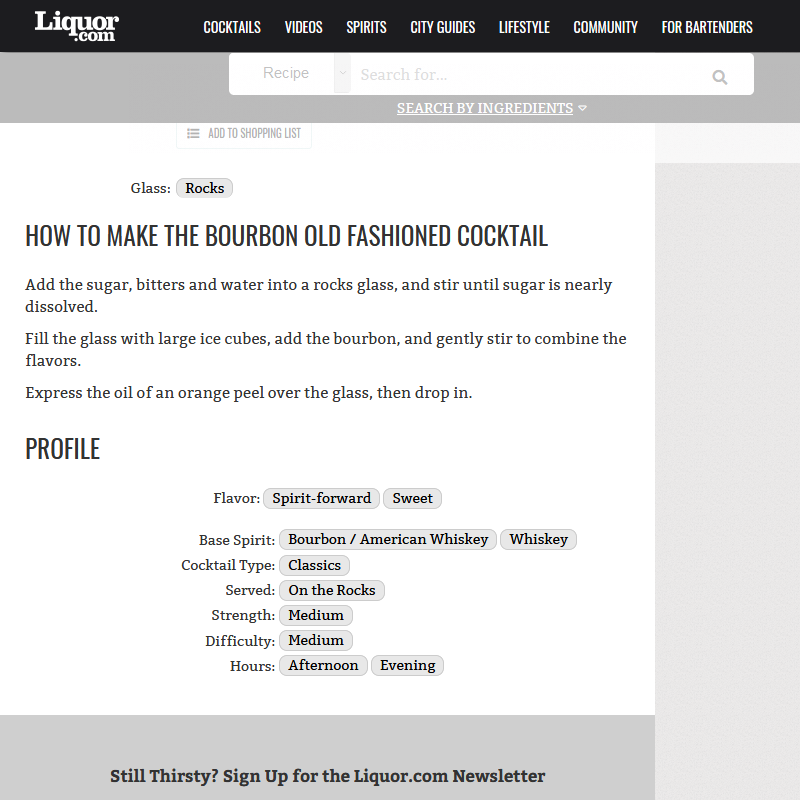

name: Bourbon Old Fashioned
author: Liquor.com
description: When you get right down to it, the Bourbon Old Fas...


,name,author,description,ingredients,garnish,glass,instructions,flavor,spirit,type,served,preparation,strength,difficulty,hours,occasions,themes,brands,collections,facebook,twitter,pinterest,yumly,email,printer,websites,url,creation_dtg,retrieval_dtg
0,Bourbon Old Fashioned,Liquor.com,"When you get right down to it, the Bourbon Old...",1/2 tsp Sugar 3 dashes Angostura bitters 1 t...,Orange peel,Rocks,"Add the sugar, bitters and water into a rocks ...",Spirit-forward Sweet,Bourbon / American Whiskey Whiskey,Classics,On the Rocks,,Medium,Medium,Afternoon Evening,,,,3481,4266,414,4587,1317,2465,1353,http://angosturabitters.com,https://www.liquor.com/recipes/bourbon-old-fas...,2013-09-28 04:00:14,2019-04-09 13:21:52


In [8]:
# Retrieve recipe from URLs and generate dataframe from parameters for further analysis

# Demo flag. Set to False to turn off screenshot and dataframe feedback
demo=True

# Launch headless browser and navigate to destination
firefox_options = Options()
firefox_options.add_argument("--headless")
firefox_profile = webdriver.FirefoxProfile()
firefox_profile.set_preference("browser.privatebrowsing.autostart", True)

browser = webdriver.Firefox(firefox_profile=firefox_profile,options=firefox_options)
browser.set_window_size(1000, 1000) 
browser.execute_script("document.body.style.zoom='.65'")

# Only scrape one page for demo
if demo==True:
    urls==list(urls[0])

# Loop through all URLs
for url in urls:
    if demo==False:
        time.sleep(5)
    browser.get(url)
    time.sleep(5)
    if demo==True:
        # Scroll to recipe section
        element = browser.find_element_by_class_name("x-recipe-ingredients")
        browser.execute_script("arguments[0].scrollIntoView();", element)
        # Render screenshot of page
        png1 = browser.get_screenshot_as_png()
        display(Im.open(io.BytesIO(png1)).crop((0,0,800,800)))
    
    # Convert page source into BeautifulSoup object tree for searching
    src = browser.page_source
    soup = BeautifulSoup(src, 'html.parser')
    
    # Find and extract name, author and description
    name = ''
    author = ''
    description = ''
    try:
        name = soup.find("h1", attrs={"itemprop": "name"}).text.strip() # Use strip to remove any trailing white spaces
    except:
        pass
    try:
        author = soup.find("span", attrs={"itemprop": "author"}).text.strip()
    except:
        pass
    try:
        description = soup.find("span", attrs={"itemprop": "description"}).text.strip()
    except:
        pass
    
    # Print results
    print('name: ' + name)
    print('author: ' + author)
    print('description: ' + description[:50] + '...')
    
    # Extract remaining information
    ingredients = ''
    garnish = ''
    glass = ''
    instructions = ''
    flavor = ''
    spirit = ''
    ctype = ''
    served = ''
    preparation = ''
    strength = ''
    difficulty = ''
    hours = ''
    occasions = ''
    themes = ''
    brands = ''
    collections = 0
    facebook = 0
    twitter = 0
    pinterest = 0
    yumly = 0
    email = 0
    printer = 0
    websites = ''
    creation_dtg = ''
    dtg = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    try:
        in1 = soup.find_all("div", attrs={"itemprop": "recipeIngredient"})
        for in2 in in1: # Find and combine list of ingredients with double space delimiter
            ingredients = ingredients + in2.text.strip().replace('⁄','/').replace('\xa0',' ').replace('  ',' ') + '  '
        ingredients = ingredients.strip()
    except:
        pass
    try:
        in1 = list(set(soup.find("div", attrs={"class": "row x-recipe-garnish"}).find_all("span", attrs={"class": "oz-value"})))
        for in2 in in1:
            garnish = garnish + in2.text.strip().replace('⁄','/').replace('\xa0',' ').replace('  ',' ') + '  '
        garnish = garnish.strip()
    except:
        pass
    try:
        glass = soup.find("div", attrs={"class": "col-xs-9 recipe-link x-recipe-glasstype no-padding"}).text.strip()
    except:
        pass
    try:
        in1 = soup.find("div", attrs={"itemprop": "recipeInstructions"}).find_all('p')
        for in2 in in1:
            instructions = instructions + in2.text.strip().replace('  ',' ') + '  '
        instructions = instructions.strip()
    except:
        pass
    try:
        in1 = soup.find("div", attrs={"class": "col-xs-12 text-center x-recipe-flavor recipe-link"}).find_all('a')
        for in2 in in1:
            flavor = flavor + in2.text.strip().replace('  ',' ') + '  '
        flavor = flavor.strip().replace('Flavor: ','')
    except:
        pass
    try:
        in1 = soup.find("div", attrs={"class": "col-xs-7 x-recipe-spirit"}).find_all('a')
        for in2 in in1:
            spirit = spirit + in2.text.strip().replace('  ',' ') + '  '
        spirit = spirit.strip()
    except:
        pass
    try:
        ctype = soup.find("div", attrs={"class": "col-xs-7 x-recipe-type"}).text.strip()
    except:
        pass
    try:
        served = soup.find("div", attrs={"class": "col-xs-7 x-recipe-served"}).text.strip()
    except:
        pass
    try:
        preparation = soup.find("div", attrs={"class": "col-xs-7 x-recipe-preparation"}).text.strip()
    except:
        pass
    try:
        strength = soup.find("div", attrs={"class": "col-xs-7 x-recipe-strength"}).text.strip()
    except:
        pass
    try:
        difficulty = soup.find("div", attrs={"class": "col-xs-7 x-recipe-difficulty"}).text.strip()
    except:
        pass
    try:
        in1 = soup.find("div", attrs={"class": "col-xs-7 x-recipe-hours"}).find_all('a')
        for in2 in in1:
            hours = hours + in2.text.strip().replace('  ',' ') + '  '
        hours = hours.strip()
    except:
        pass
    try:
        in1 = soup.find("div", attrs={"class": "col-xs-7 x-recipe-occasions"}).find_all('a')
        for in2 in in1:
            occasions = occasions + in2.text.strip().replace('  ',' ') + '  '
        occasions = occasions.strip()
    except:
        pass
    try:
        in1 = soup.find("div", attrs={"class": "col-xs-7 x-recipe-themes"}).find_all('a')
        for in2 in in1:
            themes = themes + in2.text.strip().replace('  ',' ') + '  '
        themes = themes.strip()
    except:
        pass
    try:
        in1 = soup.find("div", attrs={"class": "col-xs-7 x-recipe-brands"}).find_all('a')
        for in2 in in1:
            brands = brands + in2.text.strip().replace(',',' ').replace('  ',' ') + '  '
        brands = brands.strip()
    except:
        pass
    try:
        collections = soup.find("span", attrs={"class": "collections_count"}).text.strip()
    except:
        pass
    try:
        facebook = soup.find("a", attrs={"data-identifier": "facebook:share"})['data-value'].strip()
    except:
        pass
    try:
        twitter = soup.find("a", attrs={"data-identifier": "twitter:tweet"})['data-value'].strip()
    except:
        pass
    try:
        pinterest = soup.find("a", attrs={"data-identifier": "pinterest:pin it"})['data-value'].strip()
    except:
        pass
    try:
        yumly = soup.find("a", attrs={"data-identifier": "yummly:share"})['data-value'].strip()
    except:
        pass
    try:
        email = soup.find("a", attrs={"data-identifier": "email:share"})['data-value'].strip()
    except:
        pass
    try:
        printer = soup.find("a", attrs={"data-identifier": "printer:print"})['data-value'].strip()
    except:
        pass
    try:
        in1 = soup.find("div", attrs={"class": "recipe-main-content row bring-in-sides-smaller pad-top"}).find_all('a')
        for in2 in in1: # Find all external hyperlinks in recipe page
            if in2.has_attr('href'):
                if 'http' in in2['href'] and not 'liquor.com' in in2['href'] and not in2['href'] in websites:
                    websites = websites + in2['href'].strip() + '  '
        websites = websites.strip()
    except:
        pass
    try:
        creation_dtg = soup.find_all("meta", attrs={"name": "sailthru.date"})[-1]['content']
    except:
        pass
    
    # Build dataframe from results variables
    df = pd.DataFrame({
         'name': [name],
         'author':[author],
         'description':[description],
         'ingredients':[ingredients],
         'garnish':[garnish],
         'glass':[glass],
         'instructions':[instructions],
         'flavor':[flavor],
         'spirit':[spirit],
         'type':[ctype],
         'served':[served],
         'preparation':[preparation],
         'strength':[strength],
         'difficulty':[difficulty],
         'hours':[hours],
         'occasions':[occasions],
         'themes':[themes],
         'brands':[brands],
         'collections':[collections],
         'facebook':[facebook],
         'twitter':[twitter],
         'pinterest':[pinterest],
         'yumly':[yumly],
         'email':[email],
         'printer':[printer],
         'websites':[websites],
         'url':[url],
         'creation_dtg':[creation_dtg],
         'retrieval_dtg':[dtg]})
    if demo==True:
        # Close browser and delete local driver log
        try:
            browser.quit()
        except:
            pass
        try:
            os.remove('geckodriver.log')
        except:
            pass
        # Show example data
        display(HTML(df.head().to_html()))
    
    # Store found URLs in SQL database
    engine=create_engine('sqlite:///cocktail.db', echo=False)
    if demo==True:
        df.to_sql("liquor_detailed_demo", engine, if_exists="append", index=False) # Store to demo database
    else:
        df.to_sql("liquor_detailed", engine, if_exists="append", index=False) # Store to regular database

## Retrieving Results for Analysis

Now that our scraper has finished and databased the results we can retrieve those results from the local database using SQL queries.

In [9]:
# Query local database for all recipe data
engine = create_engine('sqlite:///cocktail.db', echo=False)
df = pd.read_sql_query("select distinct * FROM liquor_detailed", engine)

# Format social media counts as integers
df = df.astype({"collections": int, "facebook": int, 'twitter': int, 
                "pinterest": int, "yumly": int, "email": int, "printer": int})

# Sort dataframe by cocktails appearing in most collections
df = df.sort_values(by=['collections'],ascending=False)
display(HTML(df.head().to_html()))

,name,author,description,ingredients,garnish,glass,instructions,flavor,spirit,type,served,preparation,strength,difficulty,hours,occasions,themes,brands,collections,facebook,twitter,pinterest,yumly,email,printer,websites,url,creation_dtg,retrieval_dtg
1494,Bourbon Old Fashioned,Liquor.com,"When you get right down to it, the Bourbon Old...",1/2 tsp Sugar 3 dashes Angostura bitters 1 t...,Orange peel,Rocks,"Add the sugar, bitters and water into a rocks ...",Spirit-forward Sweet,Bourbon / American Whiskey Whiskey,Classics,On the Rocks,,Medium,Medium,Afternoon Evening,,,,3475,4266,413,4581,1317,2412,1351,http://angosturabitters.com,https://www.liquor.com/recipes/bourbon-old-fas...,2013-09-28 04:00:14,2019-04-05 04:47:05
343,Margarita,Liquor.com,The Margarita is one of the most popular cockt...,2 oz Blanco tequila 1 oz Fresh lime juice 1/...,Kosher salt Lime wheel,Rocks glass,Add all the ingredients into a shaker with ice...,Fruity/Citrus-forward Sour,Tequila,Classics Margaritas,Neat/Up On the Rocks,Shaken,Medium,Medium,Afternoon Dinner/Paired with food Evening,Cinco de Mayo,Summer,Avión,3081,7407,613,3070,1187,2967,1987,,https://www.liquor.com/recipes/margarita/,2016-11-01 12:10:40,2019-04-05 00:35:41
1075,Manhattan,Liquor.com,The Manhattan was the most famous cocktail in ...,2 oz Bourbon or rye 1 oz Sweet vermouth 2 da...,Brandied cherry,Coupe,Add all the ingredients into a mixing glass wi...,Spirit-forward,Bourbon / American Whiskey Rye Whiskey Whiskey,Classics,Neat/Up,Stirred,Medium,Simple,Evening,,,Angostura,2653,1888,109,919,298,660,449,http://www.angosturabitters.com,https://www.liquor.com/recipes/manhattan-2/,2013-06-14 04:01:23,2019-04-05 03:11:18
1433,Whiskey Sour,Liquor.com,"Spirit, sugar, citrus—the original big three—c...",2 oz Bourbon 3/4 oz Fresh lemon juice 1/2 oz...,Angostura bitters,Coupe,Add all ingredients into a shaker with ice and...,Sour Sweet,Bourbon / American Whiskey,Classics,On the Rocks,Shaken,Medium,Medium,Dinner/Paired with food Evening,,,Angostura,2425,6477,298,2457,1487,1854,634,http://angosturabitters.com,https://www.liquor.com/recipes/whiskey-sour/,2014-09-10 13:22:00,2019-04-05 04:34:17
96,Bloody Mary,Liquor.com,The Bloody Mary is a vodka-soaked nutritional ...,1 Lemon wedge 1 Lime wedge 2 oz VodkaTry it ...,Parsley sprig Green olives Lime wedge Celer...,Pint,Pour some celery salt onto a small plate. Ru...,Salty/Savory Sour Spicy,Vodka,Classics,On the Rocks,Shaken,Light,Complicated,Morning/Brunch,,,Absolut,2256,10471,476,8305,1077,4507,2227,https://www.tabasco.com/,https://www.liquor.com/recipes/classic-bloody-...,2017-08-25 03:00:27,2019-04-04 23:42:42


## Identifying the Most Popular Cocktails
To get an idea of what cocktails are most popular across different sites and sharing methods, we can use a stacked bar chart of all of the sharing methods in our data frame ranked by the most popular recipes on liquor.com, using the collections count. The results of this chart are consistent with what you would expect to see on a bar menu.

In the second chart, we'll sort by all sharing values combined. There some outliers here such as the Hornitos Hot Shotty, which has been shared over 30,000 times on Facebook and the Tequila Honey Bee which was shared over 50,000 times on Pinterest. These are otherwise not in many collections or shared elsewhere. That said, this still may be helpful for understanding demographics associated with different social media sites and how that may relate to tastes.

In [10]:
# Define palette to use for Plotly charts
pal = ['#48c9b0', '#5499c7', '#ec7063', '#cd6155', '#DAF7A6', '#FFC300', 
       '#f39c12', '#e74c3c', '#8e44ad', '#16a085', '#27ae60', '#d35400']

# Define function to stack bar plot different count columns against name column
def barcols(df,cols,sortcol,n):
    df2 = df.copy()
    # Sort dataframe by specified column, drop duplicates and take top n rows
    df2 = df2.sort_values(by=[sortcol],ascending=False)
    df2 = df2.drop_duplicates(subset=['name'], keep='first')
    df2 = df2.head(n)
    traces = []
    p1 = 0
    # Loop through count columns and create bar traces
    for col in cols:
        trace1 = go.Bar(
            x=list(df2['name']),
            y=list(df2[col]),
            width=.4,
            name=col, marker=dict(
                color=pal[p1],
                line=dict(
                    color='black',
                    width=1.5)
            ),
            opacity=0.8
        )
        traces += [trace1]
        p1 += 1
    # Define layout
    layout = go.Layout(
        title='Top {} Most Shared Cocktail Recipes (Ranked by {})'.format(n,sortcol.title()),
        autosize=True,
        height=550,
        margin = dict(b=130),
        yaxis=dict(title='Shares'),
        barmode='stack'
    )
    # Execute and plot layout
    fig = go.Figure(data=traces, layout=layout)
    plotly.offline.iplot(fig)

# Create a total shares column
df['total'] = df['collections'] + df['facebook'] + df['twitter'] + df['pinterest'] + df['yumly'] + df['email'] + df['printer']

# Create stacked bar charts sorted by collections count and total share count
cols = ['collections', 'facebook', 'twitter', 'pinterest', 'yumly', 'email', 'printer']
barcols(df,cols,'collections',10)
barcols(df,cols,'total',10)

Looking at the data this way can gives some ideas on what cocktails people want to make, versus which ones have high name recognition. For instance, the Scofflaw cocktail is popular with liquor.com users, but otherwise not well known to users of social media sites. It would be interesting to find more dark horse cocktails like this in the data set.

## Analyzing Cocktails by Category
This covers the most popular cocktails, but we should also visualize our data by the most common categories seen in our data such as spirit, flavor, glass, type, ingredients and garnish. We will define a custom pie chart function to quickly plot these categories. As part of that process we will define some extra functions to extract multi-values from cells in our data frame and remove extra information such as oz measurements.

In [12]:
# Define function to expand dataframe into new rows based on multi-value columns
def explode(df,col,delimiter=','):
    df = df.copy()
    cols1 = list(df.columns)
    cols2 = cols1.copy()
    cols2.remove(col)
    df[col] = df[col].apply(lambda x: x.split(delimiter))
    df = df[col].apply(pd.Series)\
        .merge(df, right_index = True, left_index = True)\
        .drop([col], axis = 1).melt(id_vars=cols2, value_name=col).drop(['variable'], axis = 1)
    df = df[cols1]
    return df

# Define function generate offline plotly interactive pie charts of top n values for each category
def piecols(df,cols,n=10):
    # Hide legend if there are too many labels
    if n*len(cols) <= 20:
        showlegend = True
    else:
        showlegend = False
    domcol = 0
    domrow = 0
    datas = []
    # Loop through specified columns
    for col in cols:
        df1 = df.copy()
        # Drop blanks and NAs, and do basic data cleaning
        df2 = df1[df1[col] != '']
        df2 = explode(df2,col,'  ')
        df2 = df2.dropna()
        rep = r'[0-9]+(?:/[0-9]+)? (?:oz |ounces |dash |dashes )?(?:fresh )?'
        df2[col] = df2[col].apply(lambda x: re.sub(rep, '', x,flags=re.IGNORECASE))
        df2[col] = df2[col].apply(lambda x: str(x).split(' / ')[0].title())
        
        # Group by specified column and create sorted top n counts
        dfg = df2[[col,'name']].groupby(col).count()
        dfg.columns = ['count']
        dfg = dfg.sort_values(by=['count'],ascending=False)
        dfg = dfg.head(n)
        
        # Create pie chart figure dictionary for each column and append to pie figure list
        data = {"hoverinfo": "label+percent+value",
                 "labels": list(dfg.index),
                 "marker": {"colors": pal,
                            "line": {"color": "#000000", "width": 1.5}},
                "opacity": .8,
                            "pull": 0.1,
                "domain": {"column": domcol, "row": domrow},
                "title": col.title(),
                "text": ["test"],
                "textfont": {"size": 12},
                "textinfo": "percent+label",
                "textposition": "inside",
                "values": list(dfg['count']),
                "type": "pie"}
        domcol += 1
        if domcol >= 2:
            domcol = 0
            domrow += 1
        datas = datas + [data]
    
    # Generate figure layout and plot
    fig = {
              "data": datas,
              "layout": {
                    "autosize":True,
                    "height": 500 * round(.1+len(cols)/2),
                    "title":"Cocktail Popularity by Top {} Categories".format(n),
                    "legend": {"orientation":"h"}, 
                    "showlegend":showlegend,
                    "grid": {"rows": round(.1+len(cols)/2), "columns": 2}
                }
            }
    return plotly.offline.iplot(fig)
    
# Generate pie chart visualizations for different categories
piecols(df,['spirit','flavor','ingredients','glass','type','garnish'],10)

This gave us a lot of insight into the most popular components of a modern bar. Some of the most important components in cocktails are fresh citrus, like lemon and lime as well as syrups and bitters. This is also consistent with the popularity of sweet citrus-forward cocktails, that make up "modern classic" cocktails. This also gives us an idea of what the most used spirits are in cocktails. To our surprise, Rum is more popular that Vodka, Gin and Bourbon. It would be interesting to determine if this was always the case or a more recent development.

## Tracking Popularity of Different Spirits Over Time in Cocktails
Since our scraper was able to extract a hidden date in each recipe pages metadata that roughly corresponds with when the cocktail was added to the site, we can track over time the addition of new recipes categorized by different characteristics. One interesting question we could answer is whether any spirits have grown in popularity or declined in specific years in addition to tracking overall interest in new cocktail recipes on the site.

In [13]:
# Set parameters for stackplot
col = 'spirit'
yearlist = list(range(2009,2019))
spiritlist = ['Rum', 
               'Vodka', 
               'Gin', 
               'Bourbon', 
               'Tequila', 
               'Vermouth', 
               'Liqueurs', 
               'Cognac', 
               'Brandy', 
               'Scotch']

# Remove empty spirit values and expand cocktails with multiple spirits
df2 = df[df[col] != '']
df2 = explode(df2,col,'  ')
df2 = df2.dropna()
df2[col] = df2[col].apply(lambda x: str(x).split(' / ')[0])

# Create year column from creation date
df2['year'] = df2['creation_dtg'].apply(lambda x: int(str(x)[0:4]))

# Filter to previously identified top spirits and years
df2 = df2[df2[col].isin(spiritlist)]
df2 = df2[df2['year'].isin(yearlist)]

# Add up total cocktails for preceding years for each year and add zero value rows for blank year/spirit pairs
dfg = pd.DataFrame(columns=['year', 'spirit', 'count'])
for year in yearlist:
    for spirit in spiritlist:
        dfp2 = df2[(df2['year'] <= year) & (df2['spirit'] == spirit)]
        dfp2 = dfp2[[col,'name']].groupby([col]).count()
        dfp2.columns = ['count']
        dfp2['year'] = year
        dfp2 = dfp2.reset_index()
        dfp2 = dfp2[['year', 'spirit', 'count']]
        if len(dfp2) == 0:
            dfp2 = pd.DataFrame([[year, spirit, 0]], columns=['year', 'spirit', 'count'])
        dfg = pd.concat([dfg, dfp2], ignore_index=True)
dfg = dfg.astype({"year": int, "count": int})

# Create list of spirits in table ordered by last year recipe count
spirits_ordered = dfg[dfg['year']==yearlist[-1]].sort_values(by=['count'],ascending=False)[col].tolist()

# Create tuple of recipe count arrays for each spirit to pass to stack plot function
plotlist = (dfg[dfg[col]==spirits_ordered[0]]['year'].values,)
for spirit in spirits_ordered:
    plotlist = plotlist + (dfg[dfg[col]==spirit]['count'].values,)
    
# Create stack plot of annual new recipes by spirit in dataset over time
def stackplots(plotlist,spiritlist,title):
    data = []
    for y1 in range(1,len(plotlist)):
        data = data + [dict(x=plotlist[0],
                            y=plotlist[y1],
                            name=spiritlist[y1-1],
                            hoverinfo='x+y+name',
                            mode='lines',line=dict(width=1.5,color=pal[y1]),stackgroup='one')]
    layout = go.Layout(
        title=title,
        width=900, height=600,
        legend=dict(x=1,y=.4, bgcolor='rgba(0,0,0,0)'),
        yaxis=dict(title='cocktail recipes')
    )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig, validate=False)
    
# Create stack plot of annual total recipes by spirit in dataset over time
stackplots(plotlist,spiritlist,title='Total Cocktail Recipes Over Time (Annually)')

Observing the total cocktail recipes over time is helpful for tracking the overall increase in new cocktail recipes, but we may be able to pinpoint trends and years of significance if we plot our data as new recipes per year for each ingredient.

In [14]:
# Remove empty spirit values and expand cocktails with multiple spirits
df2 = df[df[col] != '']
df2 = explode(df2,col,'  ')
df2 = df2.dropna()
df2[col] = df2[col].apply(lambda x: str(x).split(' / ')[0])

# Create year column from creation date
df2['year'] = df2['creation_dtg'].apply(lambda x: int(str(x)[0:4]))

# Filter to previously identified top spirits and years
df2 = df2[df2[col].isin(spiritlist)]
df2 = df2[df2['year'].isin(yearlist)]

# Group and count by sprit and year
dfg = df2[['year',col,'name']].groupby(['year',col]).count()
dfg.columns = ['count']
dfg = dfg.sort_values(by=['year'],ascending=True).reset_index()
dfg = dfg.astype({"year": int, "count": int})

# Add zero value rows for blank year/spirit pairs
for year in yearlist:
    for spirit in spiritlist:
        dfp2 = pd.DataFrame([[year, spirit, 0]], columns=['year', 'spirit', 'count'])
        dfg = pd.concat([dfg, dfp2], ignore_index=True)
dfg = dfg.drop_duplicates(subset=['year', 'spirit'], keep='first')

# Create list of spirits in table ordered by last year recipe count
spirits_ordered = dfg[dfg['year']==yearlist[-1]].sort_values(by=['count'],ascending=False)[col].tolist()

# Create tuple of recipe count arrays for each spirit to pass to stack plot function
plotlist = (dfg[dfg[col]==spirits_ordered[0]]['year'].values,)
for spirit in spirits_ordered:
    plotlist = plotlist + (dfg[dfg[col]==spirit]['count'].values,)
    
# Create stack plot of annual new recipes by spirit in dataset over time
stackplots(plotlist,spiritlist,title='New Cocktail Recipes Over Time (Annually)')

We were able to observe some interesting trends in our data. Since the website started in 2009, there was an increase in new cocktail recipes which peaked in 2012 and then declined before peaking again in 2016. While the site initially had a lot of Vodka recipes, other spirits like Gin and Bourbon became more popular. 2016 saw a huge spike in Cognac and Brandy-based cocktails and Rum has steadily increased since 2015 to become the most popular base spirit for cocktails in 2018. The spike in brandy cocktails actually coincided with spikes in brandy sales the year before and industry predictions based on the resurgence of many classic brandy cocktails like the Sidecar (Freedman, 2017). That said, the biggest jump has been Rum's resurgence in the last two years.

## Conclusion

By analyzing online cocktail recipes online, we found insights into what types of cocktails have grown in popularity over time, as well as what ingredients should be stocked in bars today to make the most cocktail recipes. We found what types of spirits would make the most drinks and what flavor profiles to target, to include which drinks are popular with users from different social media sites. By using automated data mining and specialized scraping and retrieval techniques, we were able to gain insights into a category of drinks that would not have been obvious to an outside observer.

## Bibliography

Carr, D. F. (2012, January 23). Social Analytics Cracks Case Of The Jalapeno Cocktail. Retrieved March 7, 2019, from https://www.informationweek.com/social-analytics-cracks-case-of-the-jalapeno-cocktail/d/d-id/1102415

Freedman, B. (2017, January 31). How Brandy Could Become The Next Big Thing In The Spirits World. Retrieved from https://www.forbes.com/sites/brianfreedman/2017/01/30/how-brandy-could-become-the-next-big-thing-in-the-spirits-world/

Liquor.com. (2017, March 09). Great Cocktail Recipes, Drinks and Local Bars at Liquor.com. Retrieved April 9, 2019, from https://www.liquor.com/

Millington, A. (2018, June 17). The 30 best-selling cocktails in the world in 2018. Retrieved April 6, 2019, from https://www.businessinsider.com/best-selling-cocktails-in-the-world-in-2018-2018-2

Mitchell, C. (2018, April 25). Cocktail sales continue to soar as new trends emerge. Retrieved March 7, 2019, from http://www.cga.co.uk/2018/04/26/cocktail-sales-continue-to-soar-as-new-trends-emerge/

Wall, M. (2015, August 18). From pizzas to cocktails the data crunching way. Retrieved March 7, 2019, from https://www.bbc.com/news/business-33892409